In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# DATA, CIFAR10
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
                                   

### RBIG JAX

In [3]:
#!pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax

In [4]:
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.models.itergauss import IterativeGaussianization

In [5]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import numpy as np
from functools import partial


# logging
import tqdm
#import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
x_train = x_train[0:10,:,:]

x_train = x_train + np.random.rand(*x_train.shape)

In [7]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)

In [8]:
x_train.shape

(10, 28, 28, 1)

In [14]:
# Multiscale Valero's way
A_11 = x_train[:,0:-1:2,0:-1:2,:]
A_12 = x_train[:,0:-1:2,1::2,:]
A_21 = x_train[:,1::2,0:-1:2,:]
A_22 = x_train[:,1::2,1::2,:]
x_train_Mv = np.zeros((A_11.shape[0],A_11.shape[1],A_11.shape[2],4*A_11.shape[3]))
x_train_Mv[:,:,:,0:1] = A_11
x_train_Mv[:,:,:,1:2] = A_12
x_train_Mv[:,:,:,2:3] = A_21
x_train_Mv[:,:,:,3:4] = A_22


In [15]:
def multiscale(x_train):
    x_train_M = x_train.reshape((x_train.shape[0],x_train.shape[1]//2,2,x_train.shape[2]//2,2,x_train.shape[3]))
    # x_train_M.shape
    x_train_M = np.transpose(x_train_M,(0,1,3,2,4,5))
    # x_train_M.shape
    x_train_M = x_train_M.reshape((x_train_M.shape[0],x_train_M.shape[1],x_train_M.shape[2],x_train_M.shape[3]*x_train_M.shape[4]*x_train_M.shape[5]))
    #x_train_M.shape
    return x_train_M

In [16]:
x_train_M = multiscale(x_train)
np.testing.assert_array_equal(x_train_Mv,x_train_M)

In [21]:
def un_multiscale(x_train_M):
    x_train_M_aux = x_train_M.reshape((x_train_M.shape[0],x_train_M.shape[1],x_train_M.shape[2],2,2,x_train_M.shape[3]//4))
    #print(x_train_M_aux.shape)
    x_train_M_aux = np.transpose(x_train_M_aux,(0,1,3,2,4,5))
    #print(x_train_M_aux.shape)
    x_train_M_aux = x_train_M_aux.reshape((x_train_M_aux.shape[0],x_train_M_aux.shape[1]*x_train_M_aux.shape[2],x_train_M_aux.shape[3]*x_train_M_aux.shape[4],x_train_M_aux.shape[5]))
    #print(x_train_M_aux.shape)
    return x_train_M_aux

In [22]:
x_train_M_aux = un_multiscale(x_train_M)


In [24]:
np.testing.assert_array_equal(x_train_M_aux,x_train)

In [25]:
# Collapse
def collapse(x_train_M):
    x_train_M_C = x_train_M.reshape(x_train_M.shape[0]*x_train_M.shape[1]*x_train_M.shape[2],x_train_M.shape[3])
    shape = x_train_M.shape[1]
    return x_train_M_C,shape

In [30]:
# UnCollapse
def un_collapse(x_train_1,shape):
    x_train_1_UC = x_train_1.reshape((x_train_1.shape[0]//(shape**2),shape,shape,x_train_1.shape[1]))
    return x_train_1_UC

In [31]:
x_train_M_C,shape = collapse(x_train_M)
x_train_M_C_U = un_collapse(x_train_M_C,shape)

In [33]:
np.testing.assert_array_equal(x_train_M,x_train_M_C_U)

In [38]:
from rbig_jax.models import RBIG

# initialize RBIG Params
support_extension = 10
precision = 100
max_layers = 100
zero_tolerance = 10

# initialize RBIG Model
rbig_model = RBIG(
    n_samples=x_train_M_C.shape[0], 
    n_features=x_train_M_C.shape[1], 
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    precision=precision
)

In [39]:
%%time
aux = jnp.array(x_train_M_C)

CPU times: user 3.86 ms, sys: 0 ns, total: 3.86 ms
Wall time: 3.48 ms


In [40]:
%%time
x_train_1 = rbig_model.fit_transform(aux)

CPU times: user 17 s, sys: 250 ms, total: 17.2 s
Wall time: 17.5 s


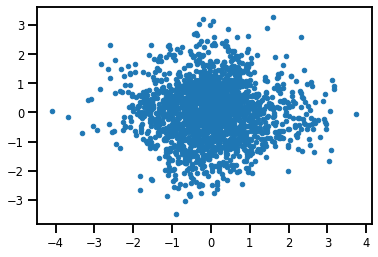

In [43]:
plt.plot(x_train_1[:,0],x_train_1[:,3],'.')

In [44]:
# UnCollapse
x_train_1_UC = x_train_1.reshape((A_11.shape[0],A_11.shape[1],A_11.shape[2],4*A_11.shape[3]))


In [45]:
x_train_1_UC.shape

(10, 14, 14, 4)

### Student-t

In [24]:

from scipy.stats import multivariate_t
import numpy as np

m = np.mean(Bv, axis = 0)
Xm = Bv - m[np.newaxis,:]
cov_matrix = np.dot(Xm.T, Xm) / Xm.shape[0]

mod_pdf = multivariate_t
mod_pdf = multivariate_t(loc = m,shape = cov_matrix,df = 3)

probs_t = mod_pdf.logpdf(Bv)

### Gauss

In [25]:
# Gauss
from scipy.stats import multivariate_normal

mod_pdf = multivariate_normal(mean = m,cov = cov_matrix)

probs_G = mod_pdf.logpdf(Bv)

### PLOTS

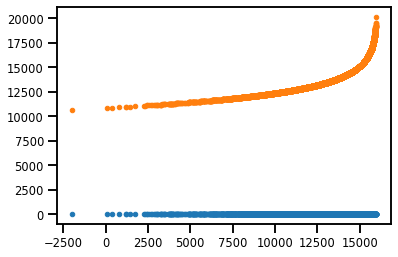

In [26]:
plt.figure
plt.plot(probs_G,prob_RBIG_JAX,'.')
plt.plot(probs_G,probs_t,'.')

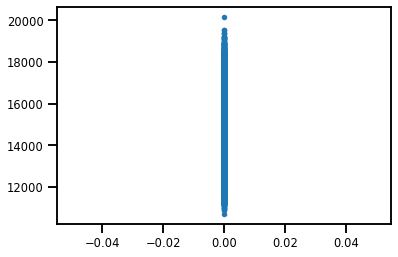

In [27]:

plt.plot(prob_RBIG_JAX,probs_t,'.')

In [28]:
prob_RBIG_JAX

DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

# Prob vs MSE

In [29]:
import tensorflow as tf


# BUCLE

In [30]:
import scipy

In [31]:
NN = 1000
#RUIDOS  = [1,3,5,10,15,20,25,30,40,50]
RUIDOS  = [5,10,20]

spear_NLPD_RMSE = np.zeros((len(RUIDOS),))
pear_NLPD_RMSE = np.zeros((len(RUIDOS),))
spear_NLPD_RMSE_PROBS_A = np.zeros((len(RUIDOS),))
pear_NLPD_RMSE_PROBS_A = np.zeros((len(RUIDOS),))

spear_NLPD_RMSE_PROBS_t = np.zeros((len(RUIDOS),))
pear_NLPD_RMSE_PROBS_t = np.zeros((len(RUIDOS),))
spear_NLPD_RMSE_PROBS_RBIG = np.zeros((len(RUIDOS),))
pear_NLPD_RMSE_PROBS_RBIG = np.zeros((len(RUIDOS),))

spear_NLPD_RMSE_PROBS_A_B = np.zeros((len(RUIDOS),))
pear_NLPD_RMSE_PROBS_A_B = np.zeros((len(RUIDOS),))
spear_NLPD_PROBS_A =  np.zeros((len(RUIDOS),))
pear_NLPD_PROBS_A = np.zeros((len(RUIDOS),))

spear_NLPD_PROBS_t =  np.zeros((len(RUIDOS),))
pear_NLPD_PROBS_t = np.zeros((len(RUIDOS),))
spear_NLPD_PROBS_RBIG =  np.zeros((len(RUIDOS),))
pear_NLPD_PROBS_RBIG = np.zeros((len(RUIDOS),))

spear_NLPD_PROBS_B = np.zeros((len(RUIDOS),))
pear_NLPD_PROBS_B = np.zeros((len(RUIDOS),))
spear_NLPD_PROBS_A_B = np.zeros((len(RUIDOS),))
pear_NLPD_PROBS_A_B = np.zeros((len(RUIDOS),))

spear_PIM_RMSE = np.zeros((len(RUIDOS),))
pear_PIM_RMSE = np.zeros((len(RUIDOS),))
spear_PIM_RMSE_PROBS_A = np.zeros((len(RUIDOS),))
pear_PIM_RMSE_PROBS_A = np.zeros((len(RUIDOS),))

spear_PIM_RMSE_PROBS_t = np.zeros((len(RUIDOS),))
pear_PIM_RMSE_PROBS_t = np.zeros((len(RUIDOS),))

spear_PIM_RMSE_PROBS_RBIG = np.zeros((len(RUIDOS),))
pear_PIM_RMSE_PROBS_RBIG = np.zeros((len(RUIDOS),))

spear_PIM_RMSE_PROBS_A_B = np.zeros((len(RUIDOS),))
pear_PIM_RMSE_PROBS_A_B = np.zeros((len(RUIDOS),))
spear_PIM_PROBS_A =  np.zeros((len(RUIDOS),))
pear_PIM_PROBS_A = np.zeros((len(RUIDOS),))

spear_PIM_PROBS_t =  np.zeros((len(RUIDOS),))
pear_PIM_PROBS_t = np.zeros((len(RUIDOS),))

spear_PIM_PROBS_RBIG =  np.zeros((len(RUIDOS),))
pear_PIM_PROBS_RBIG = np.zeros((len(RUIDOS),))

spear_PIM_PROBS_B = np.zeros((len(RUIDOS),))
pear_PIM_PROBS_B = np.zeros((len(RUIDOS),))
spear_PIM_PROBS_A_B = np.zeros((len(RUIDOS),))
pear_PIM_PROBS_A_B = np.zeros((len(RUIDOS),))

x_test_aux = x_train[0:NN,:,:,:].copy()
#x_test_aux = x_test[0:NN,:,:,:].copy()


# PROBS
Bn = x_test_aux/factor_reductor
Bv = np.reshape(Bn,[Bn.shape[0],Bn.shape[1]*Bn.shape[2]*Bn.shape[3]])
    
prob_RBIG_JAX = np.zeros(Bv.shape[0],)

cada = 1000
for n in np.arange(0,Bv.shape[0],cada):
    prob_RBIG_JAX[n:n+cada] = rbig_model.score_samples(Bv[n:n+cada,:])
    print(n)
    
mod_pdf = multivariate_t
mod_pdf = multivariate_t(loc = m,shape = cov_matrix,df = 3)
probs_t = mod_pdf.logpdf(Bv)


mod_pdf = multivariate_normal(mean = m,cov = cov_matrix)
probs_G = mod_pdf.logpdf(Bv)



i = 0
for var_rudio in RUIDOS:

    print(var_rudio)
    random_image_B = x_test_aux + var_rudio*np.random.randn(x_test_aux.shape[0],x_test_aux.shape[1],x_test_aux.shape[2],x_test_aux.shape[3])

    zero_array = np.zeros((random_image_B.shape[0],random_image_B.shape[1],random_image_B.shape[2],random_image_B.shape[3]))
    random_image_B = np.maximum(random_image_B,zero_array)

    zero_array = 255*np.ones((random_image_B.shape[0],random_image_B.shape[1],random_image_B.shape[2],random_image_B.shape[3]))
    random_image_B = np.minimum(random_image_B,zero_array)

    # PRECEPTUAL METRICS
    random_image_A_tf = tf.image.resize(x_test_aux,(32,32))
    random_image_B_tf = tf.image.resize(random_image_B,(32,32))

    PIMS = model_pim(random_image_A_tf, random_image_B_tf)
    
    NLPDS = nlpd.nlpd(random_image_A_tf, random_image_B_tf,3).numpy()
    NLPDS = np.mean(NLPDS,axis=1)

    # PROB

    Bn = random_image_B/factor_reductor
    Bv = np.reshape(Bn,[Bn.shape[0],Bn.shape[1]*Bn.shape[2]*Bn.shape[3]])
    PROBS_B = mod_pdf.logpdf(Bv)

    # RMSE
    RMSES = np.sqrt(np.mean((x_test_aux[:,:,:,:]-random_image_B[:,:,:,:])**2,axis=(1, 2,3)))

    # RESULTADOS NLPDS

    XX = NLPDS
    YY = RMSES

    spear_NLPD_RMSE[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_RMSE[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = RMSES*probs_G

    spear_NLPD_RMSE_PROBS_A[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_RMSE_PROBS_A[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    
    YY = RMSES*probs_t

    spear_NLPD_RMSE_PROBS_t[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_RMSE_PROBS_t[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = RMSES*prob_RBIG_JAX

    spear_NLPD_RMSE_PROBS_RBIG[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_RMSE_PROBS_RBIG[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = RMSES*(probs_G+PROBS_B)

    spear_NLPD_RMSE_PROBS_A_B[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_RMSE_PROBS_A_B[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = probs_G

    spear_NLPD_PROBS_A[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_PROBS_A[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = probs_t

    spear_NLPD_PROBS_t[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_PROBS_t[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = prob_RBIG_JAX

    spear_NLPD_PROBS_RBIG[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_PROBS_RBIG[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = PROBS_B

    spear_NLPD_PROBS_B[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_PROBS_B[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = probs_G+PROBS_B

    spear_NLPD_PROBS_A_B[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_NLPD_PROBS_A_B[i] = (scipy.stats.pearsonr(XX,YY)[0])

     # RESULTADOS PIMS

    XX = PIMS
    YY = RMSES

    spear_PIM_RMSE[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_RMSE[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = RMSES*probs_G

    spear_PIM_RMSE_PROBS_A[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_RMSE_PROBS_A[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    
    YY = RMSES*probs_t

    spear_PIM_RMSE_PROBS_t[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_RMSE_PROBS_t[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = RMSES*prob_RBIG_JAX

    spear_PIM_RMSE_PROBS_RBIG[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_RMSE_PROBS_RBIG[i] = (scipy.stats.pearsonr(XX,YY)[0])


    YY = RMSES*(probs_G+PROBS_B)

    spear_PIM_RMSE_PROBS_A_B[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_RMSE_PROBS_A_B[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = probs_G

    spear_PIM_PROBS_A[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_PROBS_A[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = probs_t

    spear_PIM_PROBS_t[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_PROBS_t[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    YY = prob_RBIG_JAX

    spear_PIM_PROBS_RBIG[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_PROBS_RBIG[i] = (scipy.stats.pearsonr(XX,YY)[0])
    
    
    YY = PROBS_B

    spear_PIM_PROBS_B[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_PROBS_B[i] = (scipy.stats.pearsonr(XX,YY)[0])

    YY = probs_G+PROBS_B

    spear_PIM_PROBS_A_B[i] = (scipy.stats.spearmanr(XX,YY).correlation)
    pear_PIM_PROBS_A_B[i] = (scipy.stats.pearsonr(XX,YY)[0])

    i+=1

0
5
10
20


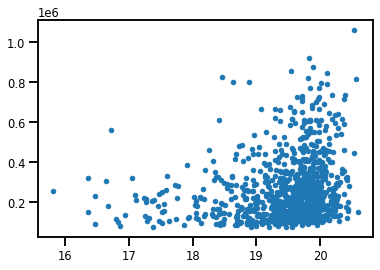

In [32]:
plt.plot(RMSES,PIMS,'.')

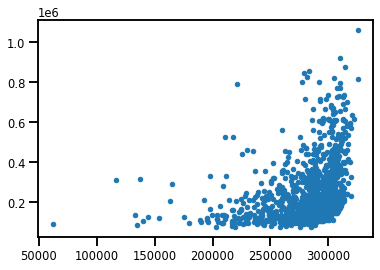

In [33]:
plt.plot(RMSES*probs_G,PIMS,'.')

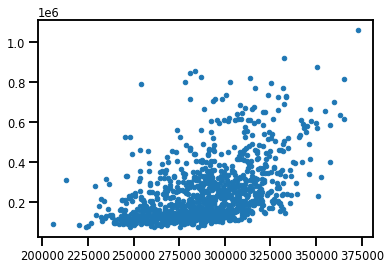

In [34]:
plt.plot(RMSES*probs_t,PIMS,'.')

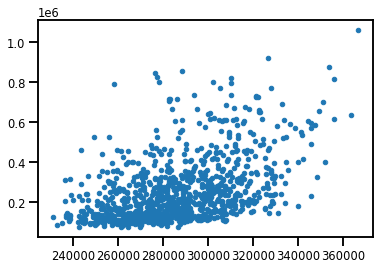

In [35]:
plt.plot(RMSES*prob_RBIG_JAX,PIMS,'.')

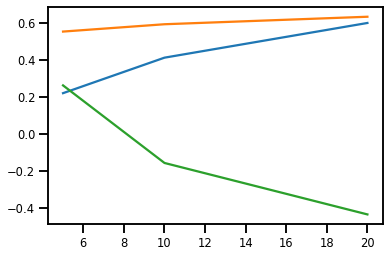

In [36]:
# Diferent options for the RMSE-based cost function
plt.plot(RUIDOS,spear_NLPD_RMSE)
plt.plot(RUIDOS,spear_NLPD_RMSE_PROBS_A)
plt.plot(RUIDOS,spear_NLPD_RMSE_PROBS_A_B)


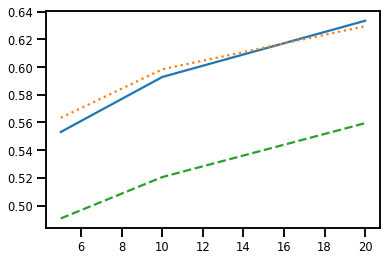

In [37]:
# spearman NLPD vs RMSE prob A
plt.plot(RUIDOS,spear_NLPD_RMSE_PROBS_A,'-')
plt.plot(RUIDOS,spear_NLPD_RMSE_PROBS_t,':')
plt.plot(RUIDOS,spear_NLPD_RMSE_PROBS_RBIG,'--')


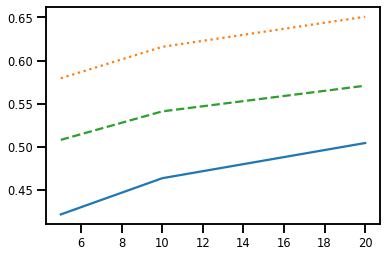

In [38]:
# pearson NLPD vs RMSE prob A
plt.plot(RUIDOS,pear_NLPD_RMSE_PROBS_A,'-')
plt.plot(RUIDOS,pear_NLPD_RMSE_PROBS_t,':')
plt.plot(RUIDOS,pear_NLPD_RMSE_PROBS_RBIG,'--')


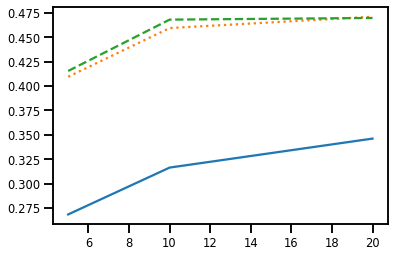

In [39]:
plt.plot(RUIDOS,pear_PIM_RMSE_PROBS_A,'-')
plt.plot(RUIDOS,pear_PIM_RMSE_PROBS_t,':')
plt.plot(RUIDOS,pear_PIM_RMSE_PROBS_RBIG,'--')


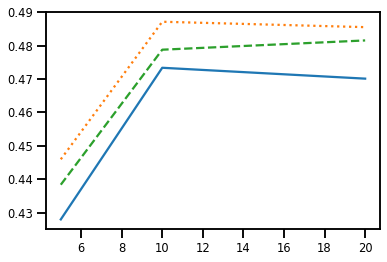

In [40]:
plt.plot(RUIDOS,spear_PIM_RMSE_PROBS_A,'-')
plt.plot(RUIDOS,spear_PIM_RMSE_PROBS_t,':')
plt.plot(RUIDOS,spear_PIM_RMSE_PROBS_RBIG,'--')


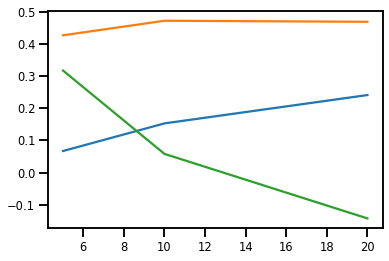

In [41]:
plt.plot(RUIDOS,spear_PIM_RMSE)
plt.plot(RUIDOS,spear_PIM_RMSE_PROBS_A)
plt.plot(RUIDOS,spear_PIM_RMSE_PROBS_A_B)


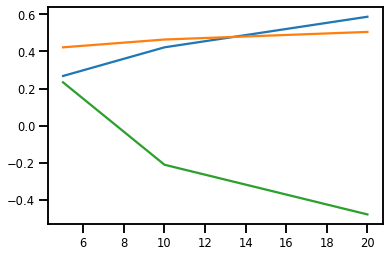

In [42]:
plt.plot(RUIDOS,pear_NLPD_RMSE)
plt.plot(RUIDOS,pear_NLPD_RMSE_PROBS_A)
plt.plot(RUIDOS,pear_NLPD_RMSE_PROBS_A_B)

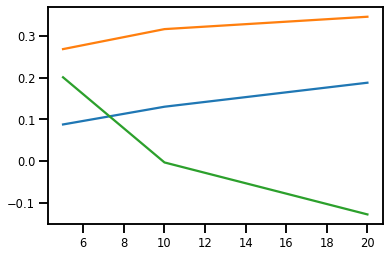

In [43]:
plt.plot(RUIDOS,pear_PIM_RMSE)
plt.plot(RUIDOS,pear_PIM_RMSE_PROBS_A)
plt.plot(RUIDOS,pear_PIM_RMSE_PROBS_A_B)

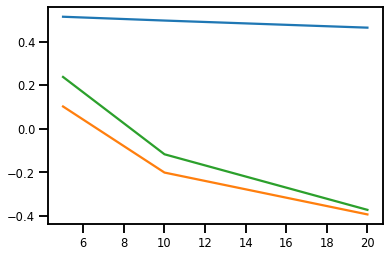

In [44]:
plt.plot(RUIDOS,spear_NLPD_PROBS_A)
plt.plot(RUIDOS,spear_NLPD_PROBS_B)
plt.plot(RUIDOS,spear_NLPD_PROBS_A_B)


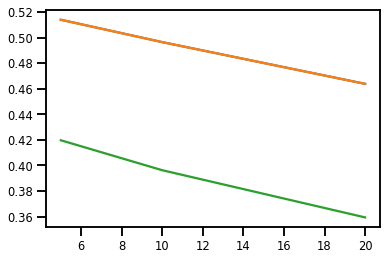

In [45]:
plt.plot(RUIDOS,spear_NLPD_PROBS_A)
plt.plot(RUIDOS,spear_NLPD_PROBS_t)
plt.plot(RUIDOS,spear_NLPD_PROBS_RBIG)


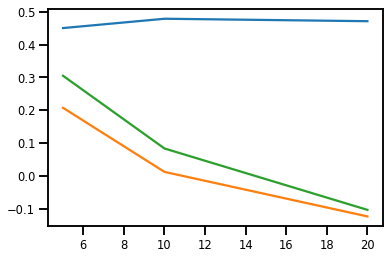

In [46]:
plt.plot(RUIDOS,spear_PIM_PROBS_A)
plt.plot(RUIDOS,spear_PIM_PROBS_B)
plt.plot(RUIDOS,spear_PIM_PROBS_A_B)


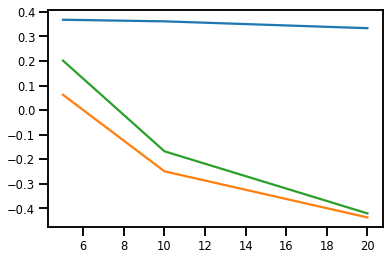

In [47]:
plt.plot(RUIDOS,pear_NLPD_PROBS_A)
plt.plot(RUIDOS,pear_NLPD_PROBS_B)
plt.plot(RUIDOS,pear_NLPD_PROBS_A_B)


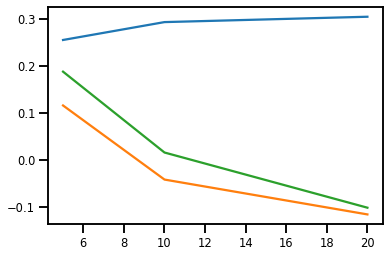

In [48]:
plt.plot(RUIDOS,pear_PIM_PROBS_A)
plt.plot(RUIDOS,pear_PIM_PROBS_B)
plt.plot(RUIDOS,pear_PIM_PROBS_A_B)
